# LDA Parameter Tuning

## Topic Coherence Measure

1) Exploration of topic coherence measure and perplexity.  
2) Using topic coherence to parameter tune.  
3) EDA on results

In [2]:
import gensim
import pyLDAvis
import pyLDAvis.gensim as ldavis

import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import LDAvariables

### Load data and run model

In [3]:
# load prior data

data = pickle.load(open('nasa_data.sav', 'rb'))
corpus = data[0]
id2word = data[1]
docs = data[2]

#df_train = pd.read_pickle("./train_df.pkl")
#df_test = pd.read_pickle("./test_df.pkl")
#df_train.head()
#docs = df_test['lemma_abstracts']
#id2word, corpus = LDAvariables.createLDAvars(docs)

In [17]:
########################
#Run model
########################

num_topics = 20
t1 = time.time()
lda_model = gensim.models.LdaMulticore(corpus, num_topics, id2word=id2word, passes=5, workers=15, 
                                       alpha=1/num_topics, eta=0.01, random_state=1)
t2 = time.time()
print("time ", t2-t1)

time  5.978208541870117


### Visualize LDA results

In [18]:
pyLDAvis.enable_notebook()

vis = ldavis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

### Evaluate results using topic coherence

#### Coherence Formula

$\displaystyle \text{Coherence} = \sum_{i<j}\text{score}(w_i, w_j)$

#### UMass (intrinsic) topic coherence

$\text{score}_{UMass}(w_i, w_j) = \log \left ( \frac{D(w_i, w_j) + 1}{D(w_i)} \right )$



http://qpleple.com/topic-coherence-to-evaluate-topic-models/

In [19]:
# from Sam's code:
# corpus = corpus, dictionary = id2word, texts = docs

#docs = df['lemma_abstracts']
lda_tc = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, 
                                                     coherence="u_mass")
topic_coherence = lda_tc.get_coherence()

print('\nCoherence Score: ', topic_coherence)


Coherence Score:  -2.589129260826249


In [20]:
lda_tc = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, 
                                                     coherence="c_v")
topic_coherence = lda_tc.get_coherence()

print('\nCoherence Score: ', topic_coherence)


Coherence Score:  0.38131759837281537


#### Coherence per topic

In [21]:
topt = lda_model.top_topics(corpus=corpus, texts=docs, coherence='c_v', topn=30, processes=15)

In [27]:
[x[1] for x in topt]

[0.46361643528591895,
 0.4565441558176985,
 0.429241279258753,
 0.4241847231504129,
 0.41911893180133825,
 0.4164862951106027,
 0.3760645867336825,
 0.3639636653582458,
 0.3605561060181586,
 0.35651166709934334,
 0.3526687504870536,
 0.34336682421763826,
 0.33764259666549007,
 0.32416491100581973,
 0.3083135346435402,
 0.30769895368592864,
 0.302574016568534,
 0.28754381285422653,
 0.280006711240228,
 0.2589684657507621]

In [10]:
docs[0]

['map',
 'characterization',
 'analysis',
 'channel',
 'valley',
 'feature',
 'titan',
 'elongate',
 'sinuous',
 'feature',
 'interpret',
 'fluvial',
 'origin',
 'identify',
 'titan',
 'data',
 'cassini',
 'image',
 'instrument',
 'cassini',
 'titan',
 'radar',
 'mapp']

### Evaluate Results using Perplexity 

In [7]:
print('\nPerplexity Score: ', lda_model.log_perplexity(corpus))


Perplexity Score:  -7.926986535620044


### Tune number of topics by maximizing topic coherence

In [22]:
# function copied from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# minor alterations made

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    cv_values = []
    umass_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5, workers=15, alpha=1/num_topics , eta=0.1, random_state=1)
        model_list.append(model)
        cv_model = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        cv_values.append(cv_model.get_coherence())
        umass_model = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        umass_values.append(umass_model.get_coherence())
        print('Number of topics =', num_topics, "complete.")

    return model_list, cv_values, umass_values

Number of topics = 5 complete.
Number of topics = 10 complete.
Number of topics = 15 complete.
Number of topics = 20 complete.
Number of topics = 25 complete.
Number of topics = 30 complete.


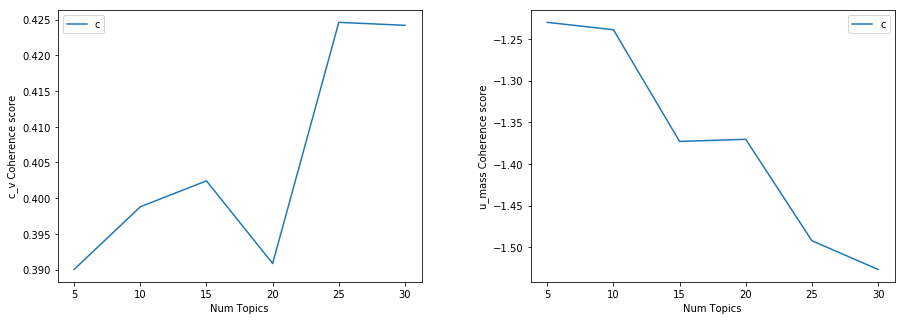

In [23]:
# plot results 

# code copied from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# minor alterations made

model_list, cv_values, umass_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=docs, start=5, limit=31, step=5)
# Show graph
limit=31; start=5; step=5;
x = range(start, limit, step)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x, cv_values)
plt.xlabel("Num Topics")
plt.ylabel("c_v Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.subplot(1,2,2)
plt.plot(x, umass_values)
plt.xlabel("Num Topics")
plt.ylabel("u_mass Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.subplots_adjust(wspace=0.3)
#plt.tight_layout()
plt.show()

In [24]:
model_list[5]

### Tune Alpha and Beta 

Two important parameters of the algorithm are:  
- Topic concentration / Beta
- Document concentration / Alpha

For the symmetric distribution, a high alpha-value means that each document is likely to contain a mixture of most of the topics, and not any single topic specifically. A low alpha value puts less such constraints on documents and means that it is more likely that a document may contain mixture of just a few, or even only one, of the topics. Likewise, a high beta-value means that each topic is likely to contain a mixture of most of the words, and not any word specifically, while a low value means that a topic may contain a mixture of just a few of the words.

If, on the other hand, the distribution is asymmetric, a high alpha-value means that a specific topic distribution (depending on the base measure) is more likely for each document. Similarly, high beta-values means each topic is more likely to contain a specific word mix defined by the base measure.
In practice, a high alpha-value will lead to documents being more similar in terms of what topics they contain. A high beta-value will similarly lead to topics being more similar in terms of what words they contain.

Source:https://medium.com/@pratikbarhate/latent-dirichlet-allocation-for-beginners-a-high-level-intuition-23f8a5cbad71

In [19]:
t1 = time.time()
lda_model = gensim.models.LdaMulticore(corpus, num_topics=20, id2word=id2word, passes=5, workers=15, 
                                       alpha=1/20 , eta=0.01, random_state=1)
t2 = time.time()
print("time ", t2-t1)

time  44.207252502441406


In [20]:
pyLDAvis.enable_notebook()

vis = ldavis.prepare(lda_model, corpus, id2word)

/home/kjl5t/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [21]:
pyLDAvis.display(vis)

In [22]:
# from Sam's code:
# corpus = corpus, dictionary = id2word, texts = docs

lda_tc = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, 
                                                     coherence="u_mass")
topic_coherence = lda_tc.get_coherence()

print('\nCoherence Score: ', topic_coherence)


Coherence Score:  -1.3845013002785493


In [23]:
lda_tc = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, 
                                                     coherence="c_v")
topic_coherence = lda_tc.get_coherence()

print('\nCoherence Score: ', topic_coherence)


Coherence Score:  0.3999935506651002


## Document-Topic results

In [98]:
########################
#Run model
########################

t1 = time.time()
lda_model = gensim.models.LdaMulticore(corpus, num_topics=20, id2word=id2word, passes=5, workers=15, 
                                       alpha=1/20, eta=0.01, random_state=1)
t2 = time.time()
print("time ", t2-t1)

time  6.106807470321655


In [8]:
# bow documents are in variable "corpus"

t = lda_model.get_document_topics(corpus[0])

In [9]:
t

[(0, 0.3694086), (2, 0.6036689)]

In [4]:
# build a data frame of document-topic results.
# each row is a document, each column is a topic

doc_topic_matrix = np.zeros((len(docs),num_topics))

i = 0
for bow in corpus:
    topics = lda_model.get_document_topics(bow)
    
    for t in topics:
        doc_topic_matrix[i,t[0]] = t[1]
    
    i = i+1
    #if i == 1000: break

doc_topic_df = pd.DataFrame(data=doc_topic_matrix)


In [5]:
doc_topic_df.head()

,0,1,2,3,4
0,0.369360,0.000000,0.603718,0.000000,0.000000
1,0.000000,0.966184,0.000000,0.000000,0.000000
2,0.960991,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.297715,0.677874
4,0.000000,0.000000,0.964512,0.000000,0.000000


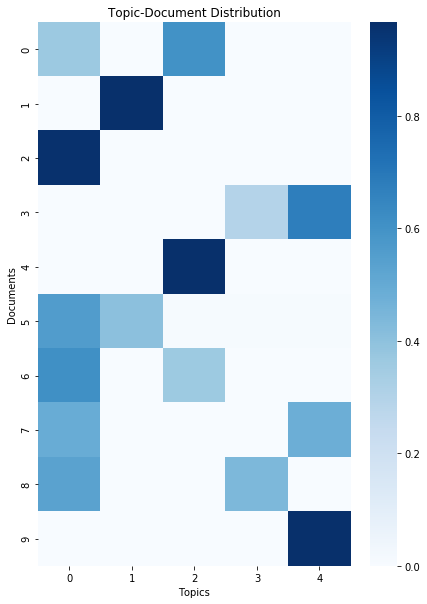

In [6]:
plt.figure(figsize=(7,10))
fig = sns.heatmap(doc_topic_df[0:10], cmap="Blues") #yticklabels=False)
plt.xlabel("Topics")
plt.ylabel("Documents")
plt.title("Topic-Document Distribution")
plt.show(fig)

In [92]:
# heatmap gives good visualization of alpha parameter

import ipywidgets as widgets
from ipywidgets import interact

In [7]:
list(doc_topic_df.columns)

[0, 1, 2, 3, 4]

In [12]:
# show the top n abstracts for each topic
n=5
top_docs =[]

for topic in doc_topic_df.columns:
    temp = doc_topic_df[topic].sort_values(ascending=False)  
    top_doc_idx = temp.index[:n]
    top_docs.append([docs[i] for i in top_doc_idx])      
    

In [14]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"data" + 0.012*"use" + 0.011*"propose" + 0.009*"solar" + 0.009*"model" + 0.008*"observation" + 0.007*"mission" + 0.006*"analysis" + 0.005*"high" + 0.005*"support"
Topic: 1 
Words: 0.019*"research" + 0.015*"nasa" + 0.010*"science" + 0.010*"space" + 0.010*"propose" + 0.010*"program" + 0.009*"mission" + 0.008*"develop" + 0.007*"support" + 0.007*"use"
Topic: 2 
Words: 0.009*"model" + 0.009*"system" + 0.009*"climate" + 0.008*"surface" + 0.007*"change" + 0.006*"water" + 0.006*"propose" + 0.005*"understand" + 0.005*"earth" + 0.005*"use"
Topic: 3 
Words: 0.015*"propose" + 0.013*"system" + 0.012*"nasa" + 0.010*"use" + 0.010*"data" + 0.008*"solar" + 0.008*"model" + 0.008*"space" + 0.007*"observation" + 0.007*"science"
Topic: 4 
Words: 0.011*"propose" + 0.008*"observation" + 0.008*"ray" + 0.008*"use" + 0.008*"galaxy" + 0.007*"high" + 0.006*"model" + 0.005*"star" + 0.005*"data" + 0.005*"emission"


In [18]:
for doc in top_docs[1]:
    print(doc)
    input()

['ohio', 'aerospace', 'institute', 'oai', 'propose', 'herein', 'continue', 'involve', 'nasa', 'glenn', 'research', 'center', 'successful', 'aeroacoustics', 'research', 'consortium', 'aarc', 'august', 'july', 'aarc', 'establish', 'partnership', 'nasa', 'glenn', 'research', 'center', 'grc', 'originally', 'boeing', 'aircraft', 'engine', 'honeywell', 'foster', 'collaborative', 'research', 'knowledge', 'exchange', 'aeroacoustics', 'sponsor', 'research', 'interaction', 'world', 'class', 'aeroacoustics', 'researcher', 'subsequently', 'pminership', 'expanded', 'pratt', 'whitney', 'roll', 'royce', 'time', 'participant', 'nasa', 'glenn', 'research', 'center', 'boeing', 'honeywell', 'pratt', 'whitney', 'roll', 'royce', 'consortium', 'conclude', 'thirteenth', 'year', 'successful', 'operation', 'oai', 'propose', 'work', 'carry', 'cooperative_agreement', 'oai', 'nthe', 'nasa', 'aeronautics', 'research', 'mission_directorate', 'research', 'program', 'underwent', 'significant', 'reshape', 'acoustic', 

['air_traffic', 'demand', 'national_airspace', 'system', 'nas', 'forecast', 'double', 'year', 'unfortunately', 'present', 'air_traffic', 'control', 'atc', 'system', 'already', 'strain', 'cannot', 'scale', 'meet', 'demand', 'moreover', 'advent', 'unmanned_aerial', 'system', 'share', 'nas', 'situation', 'deteriorate', 'even', 'rapidly', 'restructure', 'atc', 'system', 'nasa', 'cooperate', 'nwith', 'aviation', 'administration', 'government_agency', 'develop', 'nextgen', 'design', 'greatly', 'increase', 'nas', 'capacity', 'efficiency', 'safety', 'flexibility', 'environmental', 'protection', 'need', 'transformation', 'atc', 'air_traffic', 'management', 'atm', 'allow', 'aircraft', 'autonomy', 'develop', 'major', 'component', 'transformational', 'system', 'goal', 'coordinate', 'science', 'rong', 'university', 'new_orleans', 'team', 'involve', 'researcher', 'lsu', 'support', 'ames', 'larc', 'business', 'industry', 'concern', 'air_force', 'nand', 'department', 'energy', 'atm', 'system', 'center

['national_aeronautics_space', 'association', 'nasa', 'support', 'president', 'national', 'science', 'technology', 'council_committee_stem_education', 'stem', 'increase', 'nation', 'qualify', 'diverse', 'science', 'technology_engineering_mathematics', 'stem_workforce', 'provide', 'experiential', 'mentor', 'guide', 'internships', 'educational', 'opportunity', 'students_teachers', 'educational', 'level', 'nasa', 'internship', 'part', 'internship', 'fellowship', 'scholarship', 'nifs', 'program', 'provide', 'single', 'pathway', 'students_teachers', 'engage', 'stem', 'business', 'internship', 'nasa', 'center', 'location', 'nationwide', 'university', 'space', 'research', 'association', 'usra', 'join', 'nasa', 'nation', 'increase', 'country', 'diverse', 'stem_workforce', 'share', 'vision', 'hand', 'immersive', 'educational', 'experience', 'collaboration', 'partnership', 'academic', 'professional', 'research', 'organization', 'prepare', 'next_generation', 'nasa', 'nation', 'stem_workforce', 'n

['national_aeronautics_space', 'association', 'nasa', 'support', 'president', 'national', 'science', 'technology', 'council_committee_stem_education', 'stem', 'increase', 'nation', 'qualify', 'diverse', 'science', 'technology_engineering_mathematics', 'stem_workforce', 'provide', 'experiential', 'mentor', 'guide', 'internships', 'educational', 'opportunity', 'students_teachers', 'educational', 'level', 'nasa', 'internship', 'part', 'internship', 'fellowship', 'scholarship', 'nifs', 'program', 'provide', 'single', 'pathway', 'students_teachers', 'engage', 'stem', 'business', 'internship', 'nasa', 'center', 'location', 'nationwide', 'university', 'space', 'research', 'association', 'usra', 'join', 'nasa', 'nation', 'increase', 'country', 'diverse', 'stem_workforce', 'share', 'vision', 'hand', 'immersive', 'educational', 'experience', 'collaboration', 'partnership', 'academic', 'professional', 'research', 'organization', 'prepare', 'next_generation', 'nasa', 'nation', 'stem_workforce', 'n

['propulsion', 'research', 'center', 'prc', 'uahuntsville', 'history', 'demonstrate', 'capability', 'injection', 'characterization', 'performance', 'evaluation', 'liquid', 'rocket_engine', 'component', 'prc', 'facility', 'kind', 'university', 'high', 'pressure', 'injection', 'spray', 'facility', 'evaluation', 'non', 'reactive', 'fluid', 'mechanistic', 'dynamic', 'injection', 'process', 'relevant', 'rocket', 'chamber', 'pressure', 'nand', 'high', 'pressure', 'combustion', 'test', 'stand', 'cryogenic_propellant', 'delivery', 'capability', 'hot', 'fire', 'rocket_engine', 'test', 'assess', 'performance', 'characteristic', 'facility', 'engine', 'design', 'design', 'evaluate', 'academic', 'base', 'researched', 'program', 'focus', 'fundamental', 'physical', 'process', 'application', 'base', 'design', 'evaluation', 'program', 'focus', 'nrapid', 'turn', 'around', 'performance', 'assessment', 'full', 'scale', 'hardware', 'facility', 'accommodate', 'small', 'scale', 'engine', 'full', 'scale', 'co

In [102]:
pyLDAvis.enable_notebook()

vis = ldavis.prepare(lda_model, corpus, id2word)

/home/kjl5t/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [103]:
pyLDAvis.display(vis)

In [19]:
print(corpus[100])

[(0, 1), (30, 2), (47, 1), (102, 1), (301, 2), (306, 1), (329, 1), (341, 2), (426, 1), (641, 1), (863, 1), (939, 1), (1042, 1), (1043, 1), (1044, 1), (1045, 1)]


In [20]:
print(id2word[30])

research


In [77]:
print(docs[9])

['ray', 'flare', 'last', 'breath', 'inner', 'engine', 'gamma_ray_burst_grb', 'explosion', 'occur', 'approximately', 'time', 'day', 'visible', 'universe', 'consider', 'beam', 'correction', 'observe', 'routinely', 'highly_successful', 'dedicate', 'mi']


In [78]:
doc_topic_matrix[9,:]

array([0.        , 0.        , 0.        , 0.        , 0.95679075,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [107]:
lda_model.get_document_topics(corpus[9])

[(4, 0.95679075)]

In [83]:
doc_topic_matrix[100,:].sum()

0.9549500942230225

In [105]:
lda_model.print_topic(4,50)

'0.016*"ray" + 0.015*"galaxy" + 0.013*"propose" + 0.013*"observation" + 0.008*"star" + 0.008*"formation" + 0.007*"mass" + 0.007*"evolution" + 0.007*"high" + 0.006*"emission" + 0.006*"use" + 0.006*"model" + 0.006*"source" + 0.006*"planet" + 0.005*"survey" + 0.005*"cluster" + 0.005*"black_hole" + 0.005*"system" + 0.004*"gas" + 0.004*"sample" + 0.004*"disk" + 0.004*"stellar" + 0.004*"observe" + 0.004*"property" + 0.004*"planetary" + 0.004*"time" + 0.004*"data" + 0.004*"early" + 0.004*"process" + 0.004*"radio" + 0.004*"analysis" + 0.004*"accretion" + 0.004*"solar" + 0.004*"agn" + 0.004*"provide" + 0.004*"first" + 0.003*"bright" + 0.003*"large" + 0.003*"binary" + 0.003*"region" + 0.003*"galactic" + 0.003*"understand" + 0.003*"new" + 0.003*"energy" + 0.003*"investigate" + 0.003*"xmm_newton" + 0.003*"spectral" + 0.003*"origin" + 0.003*"detect" + 0.003*"dust"'

In [92]:
lda_model.print_topic(11,20)

'0.031*"nasa" + 0.024*"research" + 0.019*"space" + 0.017*"science" + 0.016*"program" + 0.012*"center" + 0.011*"system" + 0.011*"support" + 0.008*"develop" + 0.007*"earth" + 0.007*"university" + 0.007*"use" + 0.006*"technology" + 0.005*"year" + 0.005*"propose" + 0.005*"goal" + 0.005*"national" + 0.005*"global" + 0.005*"design" + 0.004*"education"'

# Topic numbers in pyLDAvis do NOT correspond to topic numbers from model!!!